In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteA9W7PM/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteA9W7PM/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteA9W7PM/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [2]:
encoder = info.features["text"].encoder #konversi text ke bags of words
print(f'Vocabulary size: {encoder.vocab_size}')


Vocabulary size: 8185


In [4]:
review = "terrible movie!"
encoded_review = encoder.encode(review) #mengubah text menjadi angka2
#kata terrible jadi vector tersendiri, movie juga. ada lokasinya juga di setiap layernya
#keluaran embedding layer yg bakal diolah
print(f'Encoded review is {encoded_review}') 

original_review = encoder.decode(encoded_review) #decode angka2 kembali menjadi text
print(f'The original review is "{original_review}" ')



Encoded review is [927, 65, 7962]
The original review is "terrible movie!" 


In [5]:
train_data, test_data = dataset['train'], dataset['test']
BUFFER_SIZE = 10000 #untuk mengacak2 kata2 (untuk menghindari bias)
BATCH_SIZE = 64 #panjang sequence
train_data = train_data.shuffle(BUFFER_SIZE) 
train_data = train_data.padded_batch(BATCH_SIZE) #apa itu padding dalam text? https://www.tensorflow.org/guide/keras/masking_and_padding
#intinya padding untuk memenuhi data huruf yang kurang panjang vectornya. 
#kalo padding dalam data numerik, data yg kurang dibuat 0
test_data = test_data.padded_batch(BATCH_SIZE)



In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, Dropout, LSTM
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Embedding(encoder.vocab_size, 64))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1)) #output neuron 
model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 635,329
Trainable params: 635,329
Non-trainable params: 0
________________________________________________

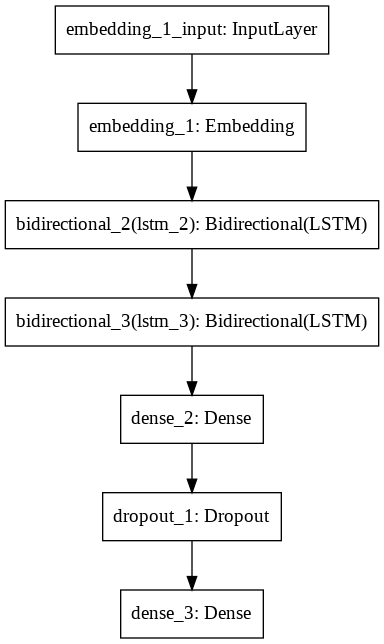

In [8]:
tf.keras.utils.plot_model(model)


In [9]:
model.compile(loss=BinaryCrossentropy(from_logits=True),
              optimizer=Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_data, 
                    epochs=10, 
                    validation_data=test_data,
                    validation_steps=30)


Epoch 1/10
391/391 [==============================] - 81s 178ms/step - loss: 0.6643 - accuracy: 0.5427 - val_loss: 0.4939 - val_accuracy: 0.7656
Epoch 2/10
391/391 [==============================] - 69s 175ms/step - loss: 0.3875 - accuracy: 0.8355 - val_loss: 0.3622 - val_accuracy: 0.8323
Epoch 3/10
391/391 [==============================] - 70s 177ms/step - loss: 0.2770 - accuracy: 0.8954 - val_loss: 0.3754 - val_accuracy: 0.8245
Epoch 4/10
391/391 [==============================] - 69s 175ms/step - loss: 0.2232 - accuracy: 0.9206 - val_loss: 0.3568 - val_accuracy: 0.8594
Epoch 5/10
391/391 [==============================] - 70s 179ms/step - loss: 0.1906 - accuracy: 0.9342 - val_loss: 0.3617 - val_accuracy: 0.8562
Epoch 6/10
391/391 [==============================] - 70s 179ms/step - loss: 0.1601 - accuracy: 0.9496 - val_loss: 0.3942 - val_accuracy: 0.8464
Epoch 7/10
391/391 [==============================] - 71s 180ms/step - loss: 0.1449 - accuracy: 0.9585 - val_loss: 0.4417 - val_ac

In [10]:
test_loss, test_acc = model.evaluate(test_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


391/391 [==============================] - 31s 80ms/step - loss: 0.5148 - accuracy: 0.8500
Test Loss: 0.5147503018379211
Test Accuracy: 0.8499600291252136


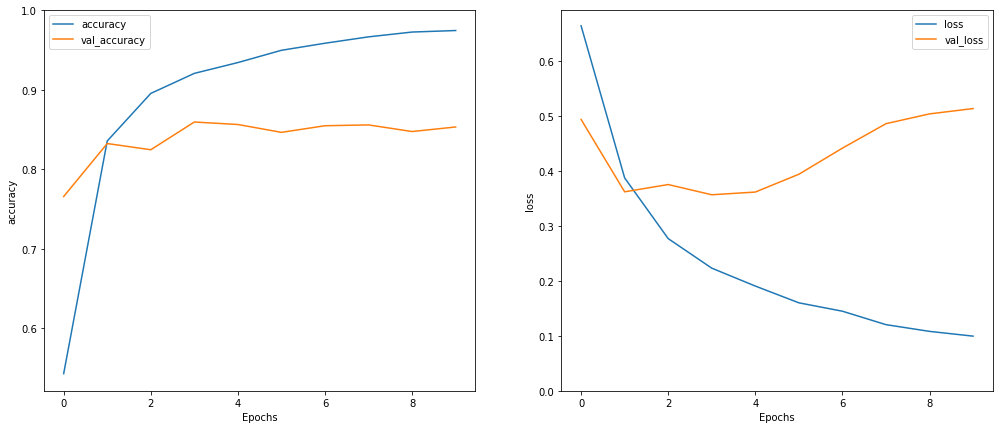

In [11]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(17, 7))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
plt.show()



In [12]:
def review_padding(encoded_review, padding_size):
    zeros = [0] * (padding_size - len(encoded_review))
    encoded_review.extend(zeros)
    return encoded_review

def review_encoder(review):
    encoded_review = review_padding(encoder.encode( review ), 64)
    encoded_review = tf.cast( encoded_review,  tf.float32)
    return tf.expand_dims( encoded_review, 0)

fight_club_review = 'It has some cliched moments, even for its time, \
but FIGHT CLUB is an awesome film. I have watched it \
about 100 times in the past 20 years. It never gets old. It \
is hard to discuss this film without giving things away but \
suffice it to say, it is a great thriller with some intriguing \
twists.'

model.predict(review_encoder(fight_club_review)) #positif artinya bagus (>0.5). negatif jeleg (<0.5)


array([[2.1148183]], dtype=float32)

In [13]:
any_movie = 'The movie was not good. The animation and the graphics \
             were terrible. I would not recommend this movie.'

model.predict(review_encoder(any_movie))


array([[-3.5613031]], dtype=float32)

In [17]:
mission_impossible_review = 'Worst movie!'

model.predict(review_encoder(mission_impossible_review)) #ini ada bias, yg jadi kelemahan model kita
#cara ngehandlenya: dicoba cara lain dengan text vectorization (encoding dan decoding data2 nya)


array([[2.5654392]], dtype=float32)